Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 1 accuracy= 0.550000
Epoch: 2 accuracy= 0.550000
Epoch: 3 accuracy= 0.700000
Epoch: 4 accuracy= 0.750000
Epoch: 5 accuracy= 0.800000
Epoch: 6 accuracy= 0.800000
Epoch: 7 accuracy= 0.850000
Epoch: 8 accuracy= 0.850000
Epoch: 9 accuracy= 0.900000
Epoch: 10 accuracy= 0.900000
Epoch: 11 accuracy= 0.900000
Epoch: 12 accuracy= 0.900000
Epoch: 13 accuracy= 0.900000
Epoch: 14 accuracy= 0.950000
Epoch: 15 accuracy= 0.950000
Ep

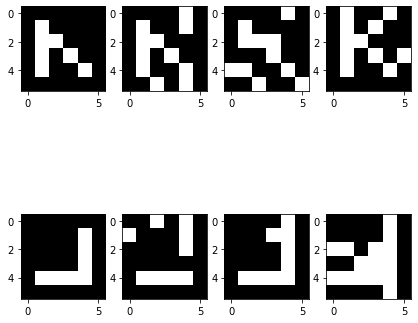

In [1]:
import numpy as np
import tensorflow as tf
#from libs.connections import linear 
from keras.utils import np_utils 
import matplotlib.pyplot as plt
%matplotlib inline

def linear(x, n_units, scope=None, stddev=0.02,
           activation=lambda x: x):
    """Fully-connected network.
    Parameters
    ----------
    x : Tensor
        Input tensor to the network.
    n_units : int
        Number of units to connect to.
    scope : str, optional
        Variable scope to use.
    stddev : float, optional
        Initialization's standard deviation.
    activation : arguments, optional
        Function which applies a nonlinearity
    Returns
    -------
    x : Tensor
        Fully-connected output.
    """
    shape = x.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], n_units], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        return activation(tf.matmul(x, matrix))


# 그래프 리셋
tf.reset_default_graph()
# 재현성을 위해 시드 지정
tf.set_random_seed(1); np.random.seed(1)
# true images
A=np.array([[0,0,0,0,0,0], [0,1,0,0,0,0],[0,1,1,0,0,0],[0,1,0,1,0,0],[0,1,0,0,1,0],[0,0,0,0,0,0]])
B=np.array([[0,0,0,0,0,0], [0,0,0,0,1,0],[0,0,0,0,1,0],[0,0,0,0,1,0],[0,1,1,1,1,0],[0,0,0,0,0,0]])

# 훈련 데이터 생성 
trainX=np.zeros((20,36))
for i in range(10):
    trainX[i,:]=A.reshape(1,6*6)
    trainX[i+10,:]=B.reshape(1,6*6)
train_x=trainX.reshape(720,1)
noise=np.random.choice(np.arange(2), 720, replace=True,p=[0.9,0.1])
v=np.where(noise>0)
train_x[v]=np.abs(train_x[v]-1)
trainX=train_x.reshape(20,36)
train_y=np.concatenate((np.ones((10,1)),np.zeros((10,1))),axis=0)
train_y=np.array(train_y, np.int64)
trainY = np_utils.to_categorical(train_y, 2)

# 훈련 데이터 이미지
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
for ii in range(8):
    plt.subplot(2,4,ii+1); 
    if ii<4: 
        if ii==0: plt.imshow(A,cmap='gray', interpolation='none')
        else: plt.imshow(trainX[ii,:].reshape(6,6),cmap='gray', interpolation='none')
    else: 
        if ii==4: plt.imshow(B,cmap='gray', interpolation='none')
        else: plt.imshow(trainX[ii+5,:].reshape(6,6),cmap='gray', interpolation='none')
learning_rate=0.01; epochs=20
X=tf.placeholder(tf.float32,[None,36])
X_img=tf.reshape(X,[-1,6,6,1]) 
Y=tf.placeholder(tf.float32,[None,2])
# 합성곱에 사용하는 필터 크기와 개수, 보폭 지정
K1=tf.Variable(tf.random_normal([4,4,1,4],stddev=0.01))
a1=tf.nn.conv2d(X_img, K1, strides=[1,1,1,1], padding='VALID')
# 배치정규화 
a1=tf.layers.batch_normalization(a1, training=True)
# 활성화함수 지정 
a1=tf.nn.relu(a1)
# 풀링의 종류와 크기, 보폭 지정 
h1=tf.nn.max_pool(a1,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
# 합성층의 마지막 부분을 1D로 변환
Flat=tf.reshape(h1,[-1,np.prod(h1.get_shape().as_list()[1:4])])
# 완전 연결 신경망의 은닉층의 구조 지정
W1=tf.get_variable("W1",shape=[np.prod(h1.get_shape().as_list()[1:4]),10],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([10]))
L1=tf.matmul(Flat, W1)+b1
# 최종 출력을 위해 소프트맥스함수 지정
pred =linear(L1, 2, activation=tf.nn.softmax)
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
optim=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
correct_predict=tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
# 정분류율
accuracy=tf.reduce_mean(tf.cast(correct_predict, tf.float32))
sess=tf.Session(); sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    sess.run(optim, feed_dict={X:trainX, Y:trainY})
    acc=sess.run(accuracy, feed_dict={X:trainX, Y:trainY})
    print('Epoch: %d' %(epoch+1),'accuracy= %f' %(acc))
# 오분류율 
print('misclassification error:', 1-sess.run(accuracy, feed_dict={X:trainX, Y: trainY}))